# Interesting Findings

This notebook is used to find interesting merchants which have:
- Small consumer base with regular large purchases
- New merchants with little information

---

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import* 
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F

In [2]:
spark = (
    SparkSession.builder.appName("Findings")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.sql.debug.maxToStringFields", 3000)
    .config("spark.network.timeout", "300s")
    .config("spark.driver.maxResultSize", "4g")
    .config("spark.rpc.askTimeout", "300s")
    .config("spark.driver.memory", "8G")
    .config("spark.executor.memory", "8G")
    .getOrCreate()
)

24/10/04 17:16:59 WARN Utils: Your hostname, Cocos-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.16.33.67 instead (on interface en0)
24/10/04 17:16:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/04 17:16:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Read dataset

In [3]:
full_transaction = spark.read.parquet('../data/curated/full_transaction_with_segments')

In [4]:
full_transaction.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- take_rate: float (nullable = true)
 |-- merchant_fraud_probability: double (nullable = true)
 |-- transaction_revenue: double (nullable = true)
 |-- BNPL_revenue: double (nullable = true)
 |-- revenue_level_e: integer (nullable = true)
 |-- revenue_level_d: integer (nullable = true)
 |-- revenue_level_c: integer (nullable = true)
 |-- revenue_level_b: integer (nullable = true)
 |-- revenue_level_a: integer (nullable = true)
 |-- category_jewelry: integer (nullable = true)
 |-- category_art: integer (nullable = true)
 |-- category_television: integer (nullable = true)
 |-- category_watch: integer (nullable = true)
 |-- category_cable: integer (nullable = true)
 |-- category_repair: integer (nullable = true)
 |-- category_stock: integer (nullable = true)
 |-- category_flower: integer (nullable = true)
 |-- category_office: integer (nullable = true)
 |-- category_souvenir: integer (nullable = true)

In [5]:
fraud_merchants = full_transaction.filter(full_transaction.merchant_is_fraud == 1)
fraud_merchants.count()

3079796

In [5]:
# find unique number of fraudent merchants
fraud_merchants.select('merchant_abn').distinct().count()

1420

# Small consumer base with regular large purchase values

### Unfiltered - Merchant

In [6]:
interesting_merchants_1 = fraud_merchants.groupBy("merchant_abn") \
    .agg(F.countDistinct("user_id").alias("num_customers"),
         F.avg("merchant_fraud_probability").alias("avg_merchant_fraud_probability"),
         F.avg("dollar_value").alias("avg_purchase_value")) \
    .orderBy(F.col("avg_purchase_value").desc())
interesting_merchants_1.show(100)

+------------+-------------+------------------------------+------------------+
|merchant_abn|num_customers|avg_merchant_fraud_probability|avg_purchase_value|
+------------+-------------+------------------------------+------------------+
| 15043504837|            1|             59.77648897297805| 47381.93709086238|
| 83199298021|            1|             69.08556869902988| 37808.99908305577|
| 64094501963|            1|             54.82544465112323| 35107.58543138098|
| 28385291716|            2|            51.005586959813584|22274.942442228723|
| 62688594508|            1|             59.26385317965887|21112.567917387372|
| 74837094867|            4|             54.01775589482071| 20283.71895772995|
| 34205660775|            1|             55.00036608221548| 20276.92332368966|
| 54860127682|            4|            52.004576773495515|19071.764943251455|
| 68591542501|            1|             54.95879714353135|19057.225939917073|
| 53877856360|            3|             54.69259025

In [7]:
interesting_merchants_1.count()

1420

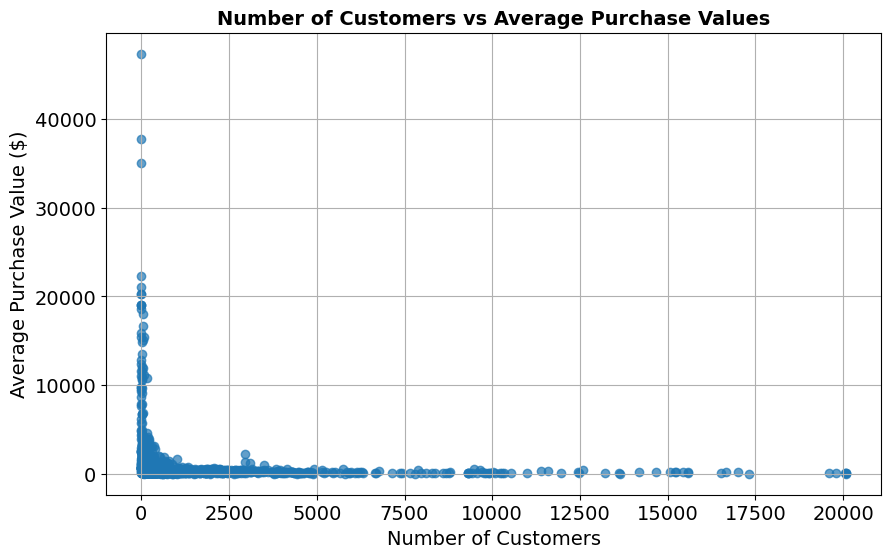

In [41]:
# Convert the PySpark DataFrame to a Pandas DataFrame properly
interesting_merchants_1_pd = interesting_merchants_1.select('num_customers', 
                                                            'avg_purchase_value').toPandas()

# Plot num_customers vs avg_purchase
plt.figure(figsize=(10, 6))
plt.scatter(interesting_merchants_1_pd['num_customers'], 
            interesting_merchants_1_pd['avg_purchase_value'], alpha=0.7)
plt.title('Number of Customers vs Average Purchase Values', fontsize=14, weight='bold')
plt.xlabel('Number of Customers', fontsize=14)
plt.ylabel('Average Purchase Value ($)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

# Display the plot
plt.savefig('../plots/num_customer_vs_avg_dollar_value.png', dpi=300, bbox_inches='tight')
plt.show()

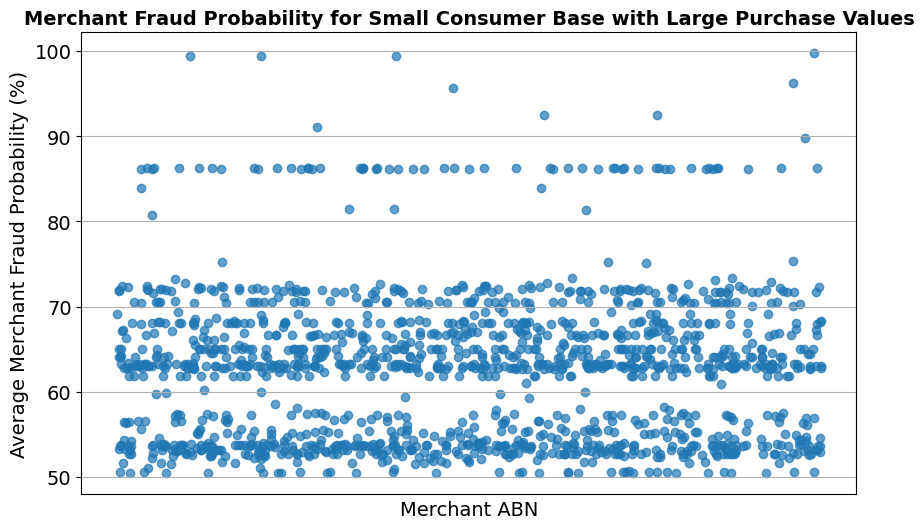

In [8]:
# Convert the PySpark DataFrame to a Pandas DataFrame properly
interesting_merchants_1_pd = interesting_merchants_1.select('merchant_abn', 
                                                            'avg_merchant_fraud_probability').toPandas()

# Plot num_customers vs avg_purchase
plt.figure(figsize=(10, 6))
plt.scatter(interesting_merchants_1_pd['merchant_abn'], 
            interesting_merchants_1_pd['avg_merchant_fraud_probability'], alpha=0.7)
plt.title('Merchant Fraud Probability for Small Consumer Base with Large Purchase Values',
           fontsize=14, weight='bold')
plt.xlabel('Merchant ABN', fontsize=14)
plt.ylabel('Average Merchant Fraud Probability (%)', fontsize=14)
plt.xticks([], [])  # Hide the x-axis tick labels but keep the x-axis label
plt.yticks(fontsize=14)
plt.grid(True)

# save and display the plot
plt.savefig('../plots/abn_vs_avg_merchant_fraud_prob.png', dpi=300, bbox_inches='tight')
plt.show()

### Unfiltered - Consumers

In [9]:
interesting_consumers_1 = fraud_merchants.groupBy("merchant_abn") \
    .agg(F.countDistinct("user_id").alias("num_customers"),
         F.avg("consumer_fraud_probability").alias("avg_consumer_fraud_probability"),
         F.avg("dollar_value").alias("avg_purchase_value")) \
    .orderBy(F.col("avg_purchase_value").desc())
interesting_consumers_1.show(100)

+------------+-------------+------------------------------+------------------+
|merchant_abn|num_customers|avg_consumer_fraud_probability|avg_purchase_value|
+------------+-------------+------------------------------+------------------+
| 15043504837|            1|             85.87123303878818| 47381.93709086238|
| 83199298021|            1|            55.876832987364644| 37808.99908305577|
| 64094501963|            1|             14.85828117544668| 35107.58543138098|
| 28385291716|            2|            22.443104140149224|22274.942442228723|
| 62688594508|            1|            35.780937947892255|21112.567917387372|
| 74837094867|            4|            16.305669047172962| 20283.71895772995|
| 34205660775|            1|            31.778811226623194| 20276.92332368966|
| 54860127682|            4|            18.510964645834157|19071.764943251455|
| 68591542501|            1|             13.65621839694564|19057.225939917073|
| 53877856360|            3|             13.57278878

In [12]:
interesting_consumers_1.count()

1420

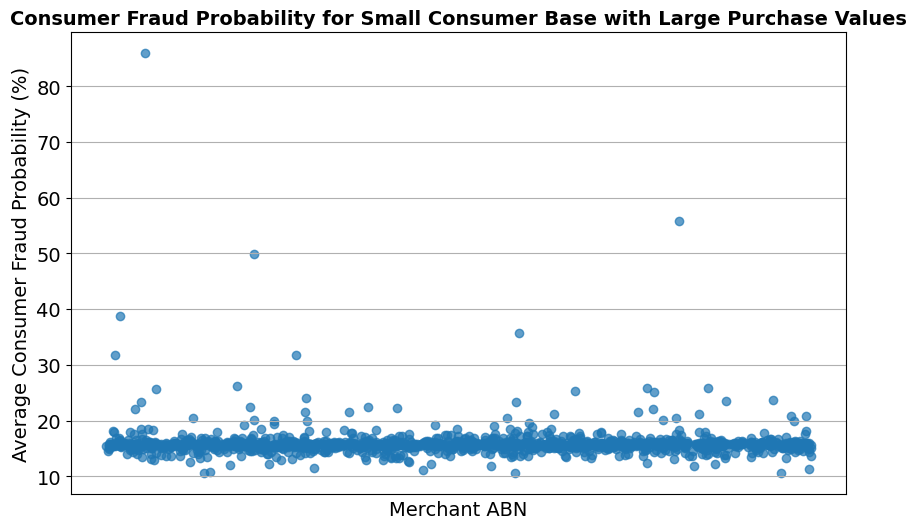

In [10]:
# Convert the PySpark DataFrame to a Pandas DataFrame properly
interesting_consumers_1_pd = interesting_consumers_1.select('merchant_abn', 
                                                            'avg_consumer_fraud_probability').toPandas()

# Plot num_customers vs avg_purchase
plt.figure(figsize=(10, 6))
plt.scatter(interesting_consumers_1_pd['merchant_abn'], 
            interesting_consumers_1_pd['avg_consumer_fraud_probability'], alpha=0.7)
plt.title('Consumer Fraud Probability for Small Consumer Base with Large Purchase Values',
           fontsize=14, weight='bold')
plt.xlabel('Merchant ABN', fontsize=14)
plt.ylabel('Average Consumer Fraud Probability (%)', fontsize=14)
plt.xticks([], [])  # Hide the x-axis tick labels but keep the x-axis label
plt.yticks(fontsize=14)
plt.grid(True)

# save and display the plot
plt.savefig('../plots/abn_vs_avg_consumer_fraud_prob.png', dpi=300, bbox_inches='tight')
plt.show()

### Filtered - Merchants

In [11]:
filtered_interesting_merchants_1 = interesting_merchants_1.filter(F.col("num_customers") < 200) \
    .filter(F.col("avg_purchase_value") > 5000) \
    .orderBy(F.col("avg_purchase_value").desc())
filtered_interesting_merchants_1.show(100)

+------------+-------------+------------------------------+------------------+
|merchant_abn|num_customers|avg_merchant_fraud_probability|avg_purchase_value|
+------------+-------------+------------------------------+------------------+
| 15043504837|            1|             59.77648897297805| 47381.93709086238|
| 83199298021|            1|             69.08556869902988| 37808.99908305577|
| 64094501963|            1|             54.82544465112323| 35107.58543138098|
| 28385291716|            2|            51.005586959813584|22274.942442228723|
| 62688594508|            1|             59.26385317965887|21112.567917387372|
| 74837094867|            4|             54.01775589482071| 20283.71895772995|
| 34205660775|            1|             55.00036608221548| 20276.92332368966|
| 54860127682|            4|            52.004576773495515|19071.764943251455|
| 68591542501|            1|             54.95879714353135|19057.225939917073|
| 53877856360|            3|             54.69259025

In [28]:
filtered_interesting_merchants_1.count()

48

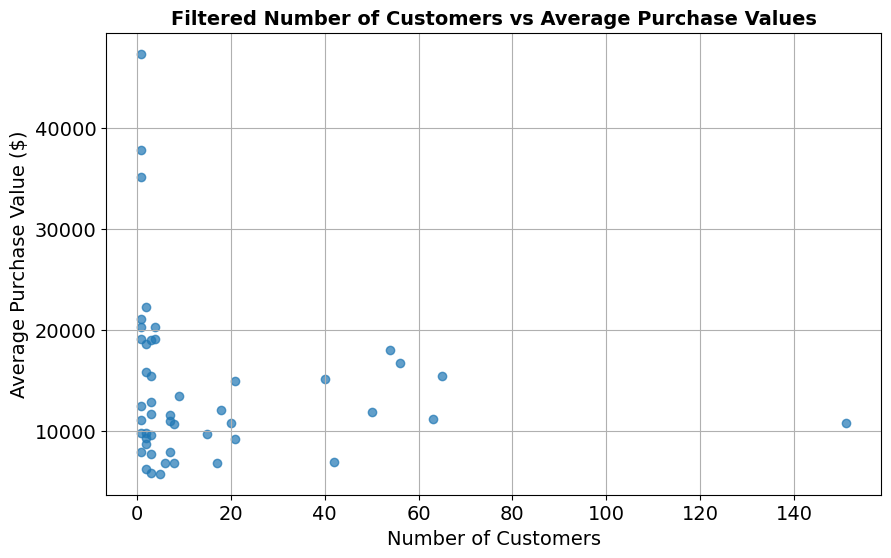

In [38]:
# Convert the PySpark DataFrame to a Pandas DataFrame properly
filtered_interesting_merchants_1_pd = filtered_interesting_merchants_1.select('num_customers', 
                                                            'avg_purchase_value').toPandas()

# Plot num_customers vs avg_purchase
plt.figure(figsize=(10, 6))
plt.scatter(filtered_interesting_merchants_1_pd['num_customers'], 
            filtered_interesting_merchants_1_pd['avg_purchase_value'], alpha=0.7)
plt.title('Filtered Number of Customers vs Average Purchase Values', fontsize=14, weight='bold')
plt.xlabel('Number of Customers', fontsize=14)
plt.ylabel('Average Purchase Value ($)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

# save and display the plot
plt.savefig('../plots/filtered_num_customer_vs_avg_dollar_value.png', dpi=300, bbox_inches='tight')
plt.show()

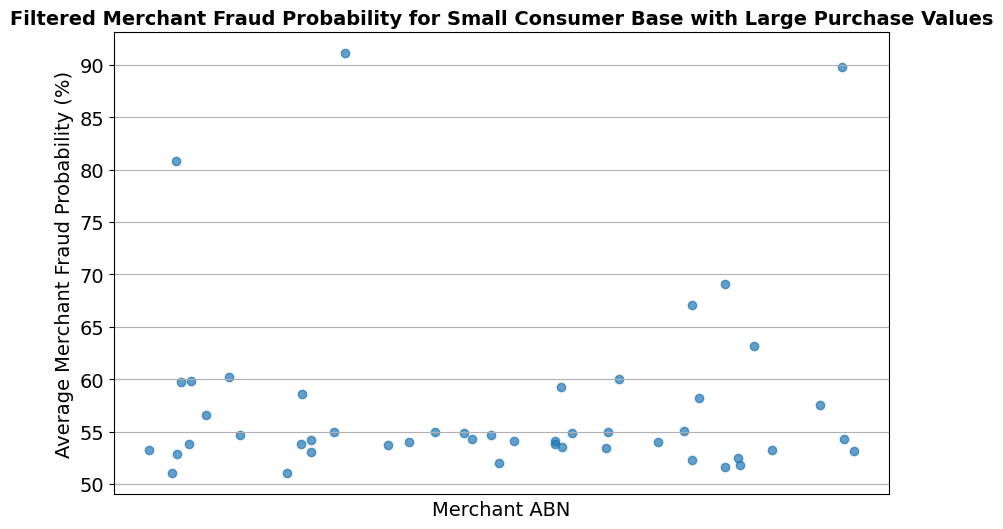

In [12]:
# Convert the PySpark DataFrame to a Pandas DataFrame properly
filtered_interesting_merchants_1_pd = filtered_interesting_merchants_1.select('merchant_abn', 
                                                            'avg_merchant_fraud_probability').toPandas()

# Plot num_customers vs avg_purchase
plt.figure(figsize=(10, 6))
plt.scatter(filtered_interesting_merchants_1_pd['merchant_abn'], 
            filtered_interesting_merchants_1_pd['avg_merchant_fraud_probability'], alpha=0.7)
plt.title('Filtered Merchant Fraud Probability for Small Consumer Base with Large Purchase Values', 
          fontsize=14, weight='bold')
plt.xlabel('Merchant ABN', fontsize=14)
plt.ylabel('Average Merchant Fraud Probability (%)', fontsize=14)
plt.xticks([], [])  # Hide the x-axis tick labels but keep the x-axis label
plt.yticks(fontsize=14)
plt.grid(True)

# save and display the plot
plt.savefig('../plots/filtered_abn_vs_avg_merchant_fraud_prob.png', dpi=300, bbox_inches='tight')
plt.show()

### Filtered - Consumers

In [13]:
filtered_interesting_consumers_1 = interesting_consumers_1.filter(F.col("num_customers") < 200) \
    .filter(F.col("avg_purchase_value") > 5000) \
    .orderBy(F.col("avg_purchase_value").desc())
filtered_interesting_consumers_1.show(100)

+------------+-------------+------------------------------+------------------+
|merchant_abn|num_customers|avg_consumer_fraud_probability|avg_purchase_value|
+------------+-------------+------------------------------+------------------+
| 15043504837|            1|             85.87123303878818| 47381.93709086238|
| 83199298021|            1|            55.876832987364644| 37808.99908305577|
| 64094501963|            1|             14.85828117544668| 35107.58543138098|
| 28385291716|            2|            22.443104140149224|22274.942442228723|
| 62688594508|            1|            35.780937947892255|21112.567917387372|
| 74837094867|            4|            16.305669047172962| 20283.71895772995|
| 34205660775|            1|            31.778811226623194| 20276.92332368966|
| 54860127682|            4|            18.510964645834157|19071.764943251455|
| 68591542501|            1|             13.65621839694564|19057.225939917073|
| 53877856360|            3|             13.57278878

In [20]:
interesting_consumers_1.count()

1420

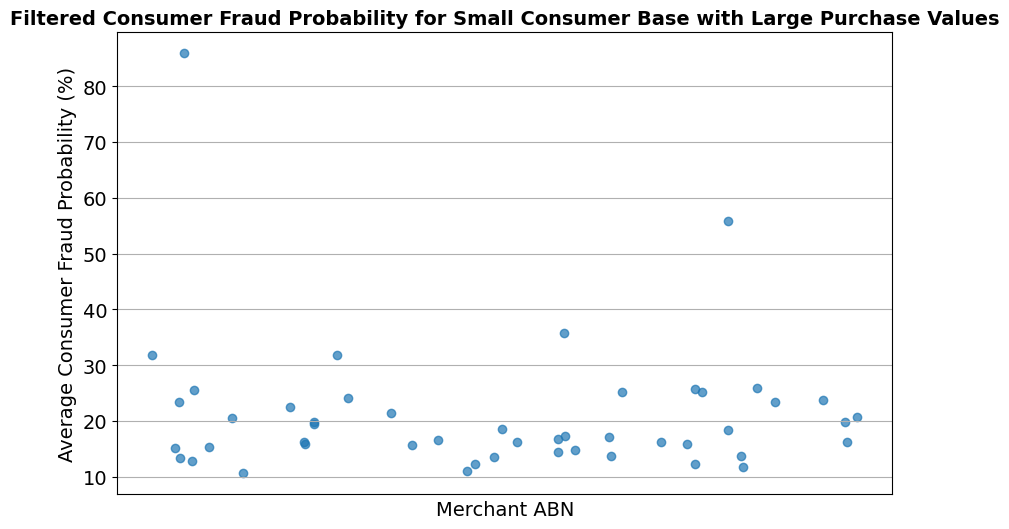

In [14]:
# Convert the PySpark DataFrame to a Pandas DataFrame properly
filtered_interesting_consumers_1_pd = filtered_interesting_consumers_1.select('merchant_abn', 
                                                            'avg_consumer_fraud_probability').toPandas()

# Plot num_customers vs avg_purchase
plt.figure(figsize=(10, 6))
plt.scatter(filtered_interesting_consumers_1_pd['merchant_abn'], 
            filtered_interesting_consumers_1_pd['avg_consumer_fraud_probability'], alpha=0.7)
plt.title('Filtered Consumer Fraud Probability for Small Consumer Base with Large Purchase Values', fontsize=14, weight='bold')
plt.xlabel('Merchant ABN', fontsize=14)
plt.ylabel('Average Consumer Fraud Probability (%)', fontsize=14)
plt.xticks([], [])  # Hide the x-axis tick labels but keep the x-axis label
plt.yticks(fontsize=14)
plt.grid(True)

# save and display the plot
plt.savefig('../plots/filtered_abn_vs_avg_consumer_fraud_prob.png', dpi=300, bbox_inches='tight')
plt.show()

# New merchants with little information

In [12]:
interesting_merchants_3 = full_transaction.groupBy("merchant_abn") \
    .agg(F.count("order_id").alias("num_orders")) \
    .filter(F.col("num_orders") < 5)
interesting_merchants_3.show()

+------------+----------+
|merchant_abn|num_orders|
+------------+----------+
| 24526454463|         3|
| 17507773571|         4|
| 29623808496|         3|
| 15457638036|         4|
| 70814127470|         3|
| 24174334793|         2|
| 80426072728|         3|
| 86621434137|         2|
| 54277261175|         4|
| 68591542501|         3|
| 88999491954|         4|
| 10441711491|         3|
| 29027010572|         4|
| 19340071232|         4|
| 78577106740|         3|
| 64648788229|         3|
| 68264859271|         3|
| 14616123867|         3|
| 76866488151|         4|
| 98082781436|         3|
+------------+----------+
only showing top 20 rows



In [13]:
interesting_merchants_3.count()

85

# Unique number of merchants in interesting facts

In [26]:
# Full outer join on merchant_abn between the three dataframes
merged_df = filtered_interesting_merchants_1.join(interesting_merchants_3, 
                                                      on="merchant_abn", how="full_outer")

# Select the unique merchant_abn count
unique_merchants = merged_df.select(F.countDistinct("merchant_abn")).collect()[0][0]

# Print the result
print(f"Number of unique merchants: {unique_merchants}")

Number of unique merchants: 684
